In [3]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

In [4]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [5]:

# @tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b."""
    return a * b

# @tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b

# @tool
def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

In [10]:

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

In [22]:
system_prompt = "You are a helpful assistant tasked with performing arithmetic on a set of inputs."
graph = create_react_agent(llm, tools=tools, state_modifier=system_prompt)


In [20]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_kaEKYyaPA1yU8rzxNFMScvEk)
 Call ID: call_kaEKYyaPA1yU8rzxNFMScvEk
  Args:
    a: 3
    b: 4
  multiply (call_wmWAoLDPm9ld9zvBoTD2nY6r)
 Call ID: call_wmWAoLDPm9ld9zvBoTD2nY6r
  Args:
    a: 7
    b: 2
  divide (call_NvBGLPocTdrlfVeK2nGqXqCb)
 Call ID: call_NvBGLPocTdrlfVeK2nGqXqCb
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================= Tool Message =================================
Name: divide

2.8
================================== Ai Message ==================================

The result of adding 3 and 4 is 7. 

When the output is multiplied 

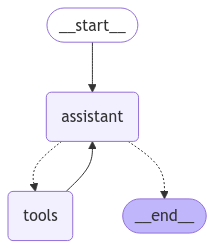

In [38]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_w4P3FZVXQrQgDpAXLwioRhgf)
 Call ID: call_w4P3FZVXQrQgDpAXLwioRhgf
  Args:
    a: 3
    b: 4
  multiply (call_VhyyXB4AHgpTAugASlmc2Tdz)
 Call ID: call_VhyyXB4AHgpTAugASlmc2Tdz
  Args:
    a: 7
    b: 2
  divide (call_B8ovcHkgV9WprDY3bXisP6F8)
 Call ID: call_B8ovcHkgV9WprDY3bXisP6F8
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================= Tool Message =================================
Name: divide

2.8
================================== Ai Message ==================================

The result of adding 3 and 4 is 7. 

When the output is multiplied 

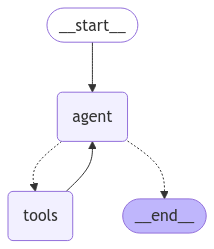

In [40]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
inputs = {"messages": [("user", "Add 3 and 4. Multiply the output by 2. Divide the output by 5")]}
# for s in graph.stream(inputs, stream_mode="values"):
#     message = s["messages"][-1]
#     if isinstance(message, tuple):
#         print(message)
#     else:
#         message.pretty_print()
for chunk in graph.stream(inputs, stream_mode="updates"):
    # print(chunk)
    for node in chunk:
        message = chunk[node]["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


================================== Ai Message ==================================
Tool Calls:
  add (call_4NphX0QN8ONg272hvTeYHsoA)
 Call ID: call_4NphX0QN8ONg272hvTeYHsoA
  Args:
    a: 3
    b: 4
  multiply (call_89CBlw9uTC6ubytY2WQepJTc)
 Call ID: call_89CBlw9uTC6ubytY2WQepJTc
  Args:
    a: 7
    b: 2
  divide (call_cLbiCnYxa8bFS7iNpULgga6e)
 Call ID: call_cLbiCnYxa8bFS7iNpULgga6e
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: divide

2.8
================================== Ai Message ==================================

The result of adding 3 and 4 is 7. 

When the output is multiplied by 2, the result is 14. 

Dividing the output by 5 gives a final result of 2.8.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful bot named Fred."),
    ("placeholder", "{messages}"),
    ("user", "Remember, always be polite!"),
])
def format_for_model(state):
    # You can do more complex modifications here
    return prompt.invoke({"messages": state["messages"]})

graph = create_react_agent(llm, tools, state_modifier=format_for_model)

inputs = {"messages": [("user", "What's your name? And what's 2 times 6?")]}
for s in graph.stream(inputs, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()